In [2]:
import numpy as np
import scipy
from scipy.interpolate import griddata
import pandas as pd
import math
import matplotlib
import matplotlib.tri as tri
import matplotlib.pyplot as plt

import dataloader as dl
import bandpower

## Plot head

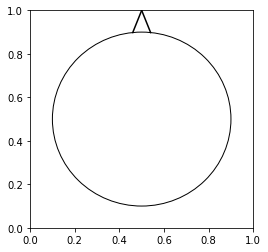

In [118]:
fig, ax = plt.subplots(figsize=(4,4))

radius = 0.4
height = (radius**2-0.04**2)**0.5

ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

# nose
ax.plot([0.46,0.5], [0.5+height,1], color='black')
ax.plot([0.5,0.54], [1,0.5+height], color='black')

# head
head = plt.Circle((0.5,0.5), radius, color='black', fill=False)
ax.add_artist(head)


## Read channel info

In [24]:
# Read channel locations
channel_info = pd.read_csv('./Channel_location_angle.csv')
channel_info = channel_info.to_numpy()
num_channels = channel_info.shape[0]

# Read data
X, Y, channel_order = dl.read_data([1,2,3])
powers = bandpower.get_bandpower(X)
sample_power = powers[0,:,:]

# Read channel values
values = np.reshape(sample_power[:,0], (num_channels,1))
channel_info = np.concatenate((channel_info, values), axis=1)
print(channel_info)


Event 1 X shape:  (324, 21, 512)
Event 2 X shape:  (546, 21, 512)
Event 3 X shape:  (226, 21, 512)
Combined X shape:  (1096, 21, 512)
[['Cz' 0.0 0.0 0.8964902352665065]
 ['C3' 0.4 180.0 2.1497596624660007]
 ['C4' 0.4 0.0 0.7985701267370873]
 ['T7' 0.8 180.0 0.9857109291652755]
 ['T8' 0.8 0.0 3.3853320683119303]
 ['Fz' 0.4 90.0 1.5239011304051666]
 ['F3' 0.5820000000000001 127.63 8.672692573506126]
 ['F4' 0.5820000000000001 53.37 7.337302655962416]
 ['F7' 0.8 144.0 3.3807416921872697]
 ['F8' 0.8 36.0 5.361897156345741]
 ['Pz' 0.4 270.0 1.874952332620282]
 ['P3' 0.5820000000000001 233.37 2.417509398858072]
 ['P4' 0.5820000000000001 306.63 2.0111413242521867]
 ['P7' 0.8 216.0 12.699310488173857]
 ['P8' 0.8 324.0 8.9141069329175]
 ['Fpz' 0.8 90.0 2.179088410922879]
 ['Fp1' 0.8 108.0 2.527906962673048]
 ['Fp2' 0.8 72.0 1.7434257909079827]
 ['Oz' 0.8 270.0 7.36814999972443]
 ['O1' 0.8 252.0 4.484422328820738]
 ['O2' 0.8 288.0 9.659366405838727]]


## Plot contour plot 

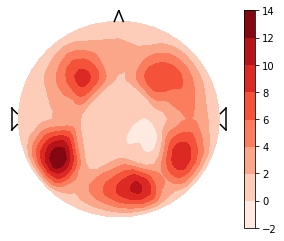

In [25]:
fig, ax = plt.subplots(figsize=(5,4))
n_angles = 48
n_radii = 1000
max_radius = 0.9
radii = np.linspace(0, max_radius, n_radii)
angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
   

# Calculate channel locations on the plot
scale_radius = max_radius*channel_info[:,1]
plot_loc = np.zeros((num_channels, 2)) # first for x, second for y
plot_loc[:,0] = scale_radius*np.cos(np.array(channel_info[:,2]*np.pi/180, dtype = np.float))
plot_loc[:,1] = scale_radius*np.sin(np.array(channel_info[:,2]*np.pi/180, dtype = np.float))

# Add couple of zeros to outline for interpolation
add_x = np.reshape(max_radius*np.cos(angles), (len(angles), 1))
add_y = np.reshape(max_radius*np.sin(angles), (len(angles), 1))
add_element = np.concatenate((add_x, add_y), axis=1)
plot_loc = np.concatenate((plot_loc, add_element), axis=0)
channel_append = np.concatenate((channel_info[:,3], np.zeros(len(angles))))

# Interpolate 
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1) 
x = (radii * np.cos(angles)).flatten()
y = (radii * np.sin(angles)).flatten()
z = griddata(plot_loc, channel_append, (x, y), method = 'cubic', fill_value=0, rescale=True)

triang = tri.Triangulation(x, y)

ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
tcf = ax.tricontourf(triang, z, cmap = 'Reds')   # Reds, Greens, Blues
fig.colorbar(tcf)

# Add nose
radius = 0.4   # radius on the plot
height = (radius**2-0.04**2)**0.5
ax.plot([-0.04,0], [0.5+height,1], color='black')
ax.plot([0,0.04], [1,0.5+height], color='black')

# Add ears
ax.plot([-0.91,-0.96], [0.05, 0.1], color='black')
ax.plot([-0.96,-0.96], [0.1, -0.1], color='black')
ax.plot([-0.96,-0.91], [-0.1, -0.05], color='black')
ax.plot([0.91,0.96], [0.05, 0.1], color='black')
ax.plot([0.96,0.96], [0.1, -0.1], color='black')
ax.plot([0.96,0.91], [-0.1, -0.05], color='black')

ax.axis('off')
plt.savefig('theta_colorbar.png')


## Combine three plots

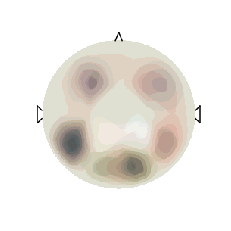

In [26]:
figure_r = plt.imread('theta.png')
figure_g = plt.imread('alpha.png')
figure_b = plt.imread('beta.png')

figure_mix = (figure_r+figure_g+figure_b)/3
plt.axis('off')
plt.imshow(figure_mix)
plt.savefig('tricontour_mix.png')

## Tricontour demo of https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/tricontour_demo.html#sphx-glr-gallery-images-contours-and-fields-tricontour-demo-py

In [56]:
# First create the x and y coordinates of the points.
n_angles = 48
n_radii = 8
min_radius = 0
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

x = (radii * np.cos(angles)).flatten()
y = (radii * np.sin(angles)).flatten()
z = (np.cos(radii) * np.cos(3 * angles)).flatten()
z = np.multiply(np.square(x), np.square(y))

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(x, y)

# Mask off unwanted triangles.
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)

Text(0.5, 1.0, 'Contour plot of Delaunay triangulation')

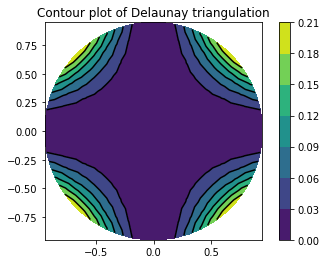

In [57]:
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tcf = ax1.tricontourf(triang, z)
fig1.colorbar(tcf)
ax1.tricontour(triang, z, colors='k')
ax1.set_title('Contour plot of Delaunay triangulation')